     Wavelength        I     step
0     545.47000  0.40742  0.00005
1     545.47005  0.40693      NaN
2     545.47010  0.40797      NaN
3     545.47015  0.40833      NaN
4     545.47020  0.40894      NaN
..          ...      ...      ...
796   545.50980  0.40589      NaN
797   545.50985  0.40565      NaN
798   545.50990  0.40498      NaN
799   545.50995  0.40589      NaN
800   545.51000  0.40608      NaN

[801 rows x 3 columns]


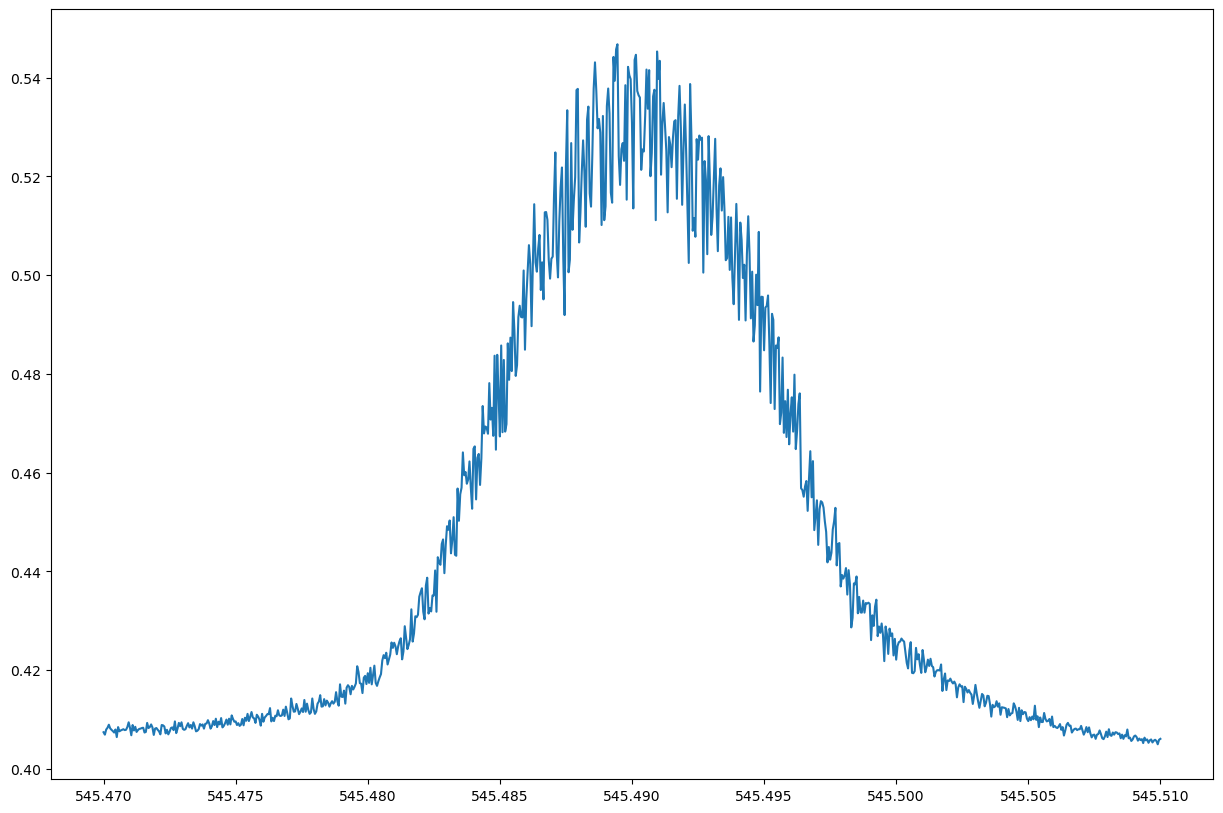

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##############
# Import data
##############

df_Hg = pd.read_csv("../Hg_Spectra_546.csv") # create pandas dataframe
print(df_Hg[: 802]) # 


##############
# Plot data
##############

x_Hg = df_Hg["Wavelength"] # grab column
y_Hg = df_Hg["I"] # grab column
plt.figure(figsize=(15,10))
plt.plot(x_Hg, y_Hg)
plt.show()

# Create a train/test split
# train_split = int(0.8 * len(X))
# X_train, y_train = x_Hg[:train_split], y_Hg[:train_split]
# X_test, y_test = x_Hg[train_split:], y_Hg[train_split:]

# print(len(X_train), len(y_train), len(X_test), len(y_train))

# instantiate DataLoader
#    we use the 4 batches of 200 obervations each (full data has 100 observations)
#    we also shuffle the data
# train_dataloader = DataLoader(training_data, batch_size=, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [13]:
x_Hg = torch.tensor(x_Hg)
y_Hg = torch.tensor(y_Hg)

# Define the model
class GaussianModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a_Hg = nn.Parameter(torch.tensor(0.12, # <- start with a random weight value
                                                requires_grad=True))
        self.mean_Hg = nn.Parameter(torch.tensor(545.491, # <- start with a random weight value
                                                requires_grad=True))
        self.sigma_Hg = nn.Parameter(torch.tensor(0.004, # <- start with a random weight value
                                                requires_grad=True))
        self.h_Hg = nn.Parameter(torch.tensor(0.410, # <- start with a random weight value
                                                requires_grad=True))
    
    def forward(self, x_Hg: torch.Tensor):
        sigma_Hg = torch.nn.functional.softplus(self.sigma_Hg)  # Ensure sigma is positive
        return (self.a_Hg * torch.exp((-(x_Hg - self.mean_Hg)**2) / (2 * sigma_Hg**2))) + self.h_Hg


# Create the model and optimizer
model = GaussianModel().to(device)

In [14]:
x_Hg = torch.tensor(x_Hg)
y_Hg = torch.tensor(y_Hg)

import torch
from torch.utils.data import Dataset, DataLoader
import random

class HgSpectraData(Dataset):
    def __init__(self, x_Hg, y_Hg, shuffle=True):
        """
        Args:
            x_Hg (list or tensor): Input 'a' data (e.g., features).
            y_Hg (list or tensor): Corresponding 'y' data (e.g., labels).
            shuffle (bool): Whether to shuffle the data.
        """
        # Ensure inputs are tensors
        self.x_Hg = torch.tensor(x_Hg, dtype=torch.float32)
        self.y_Hg = torch.tensor(y_Hg, dtype=torch.float32)
        
        # Check that x_Hg and y_Hg have the same length
        assert self.x_Hg.shape[0] == self.y_Hg.shape[0], "x_Hg and y_Hg must have the same length"
        
        self.data_len = len(self.x_Hg)
        
        # Shuffle data if required
        if shuffle:
            self.shuffle_data()
    
    def shuffle_data(self):
        """Shuffles the x_Hg and y_Hg in unison."""
        combined = list(zip(self.x_Hg, self.y_Hg))
        random.shuffle(combined)
        self.x_Hg, self.y_Hg = zip(*combined)
        self.x_Hg = torch.stack(self.x_Hg)
        self.y_Hg = torch.stack(self.y_Hg)

    def __len__(self):
        """Returns the length of the dataset."""
        return self.data_len
    
    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the data to fetch.

        Returns:
            tuple: (x_Hg, y_Hg) for the given index.
        """
        return self.x_Hg[idx], self.y_Hg[idx]

# Example usage:
# x_Hg = [[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]]
# y_Hg = [0.5, 1.5, 2.5]
dataset = HgSpectraData(x_Hg, y_Hg, shuffle=True)

loader = DataLoader(dataset, batch_size=2, shuffle=True)

In [15]:
#######################
## training the model
#######################

# Define the loss function and optimizer
loss_function = nn.MSELoss()
# Setup an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
nTrainSteps = 1000

# Training loop modifications:
for epoch in range(nTrainSteps):
    current_loss = 0.0
    for i, data in enumerate(loader, 0):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)  # Reshape if needed
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()

    if (epoch + 1) % 250 == 0:  # Print loss every 10 epochs
        print(f'Epoch {epoch+1}, Loss: {current_loss}')

# Process is complete.
print('Training process has finished.')

Epoch 250, Loss: 0.02329047462357181
Epoch 500, Loss: 0.01972155468130099
Epoch 750, Loss: 0.018758053183397294
Epoch 1000, Loss: 0.024316944859060996
Training process has finished.


In [16]:
print("Fit Amplitude: ", model.a_Hg.item(),
      "\n Fit Mean (Wavelength): ", model.mean_Hg.item(),
      "\n Fit Sigma (distance from mean to sides): ", model.sigma_Hg.item(),
      "\n Fit Height: ", model.h_Hg.item())

Fit Amplitude:  0.12678459286689758 
 Fit Mean (Wavelength):  545.4903564453125 
 Fit Sigma (distance from mean to sides):  -5.3374152183532715 
 Fit Height:  0.40769660472869873


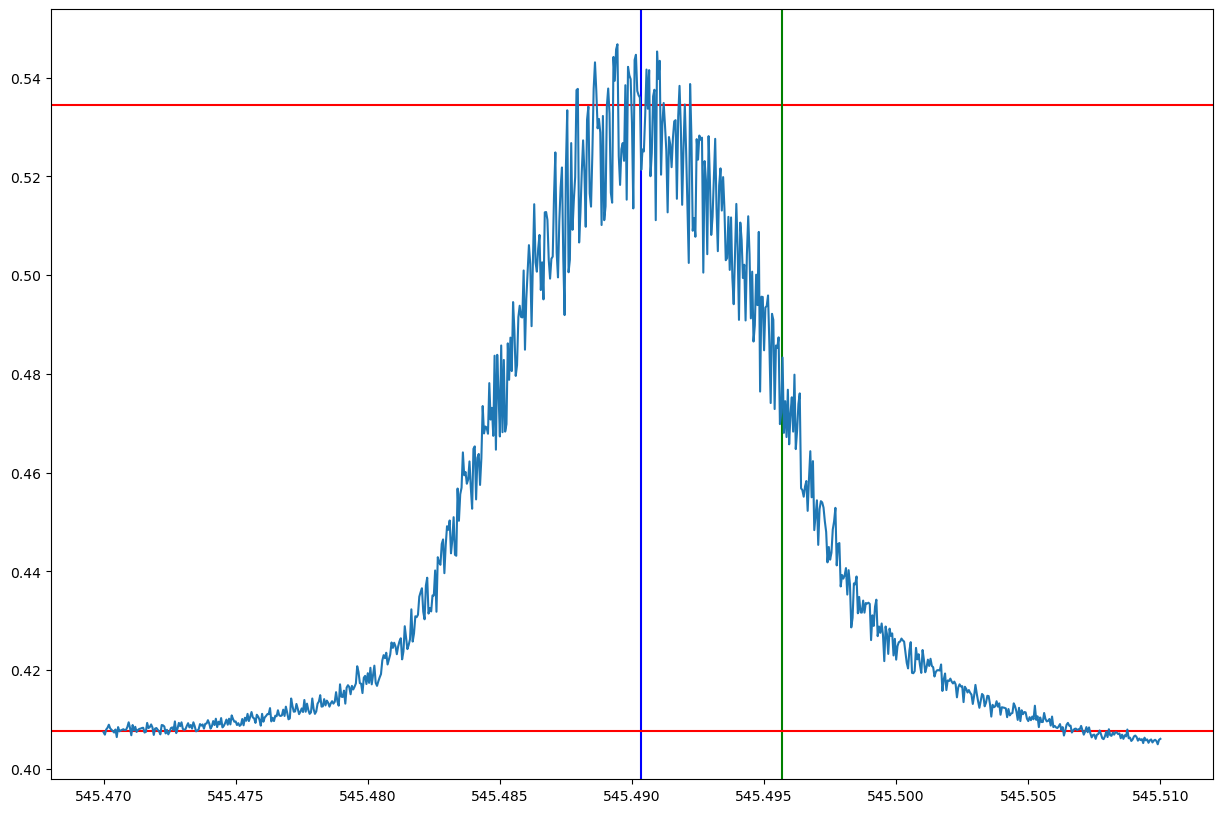

In [28]:
########
# Plot
#######

sigma_balls = model.mean_Hg.item() + (np.abs(model.sigma_Hg.item()) * 1e-3)
amp_balls = model.a_Hg.item() + model.h_Hg.item()

plt.figure(figsize=(15,10))
plt.axhline(y = amp_balls, color = 'r', linestyle = '-') 
plt.axvline(x = model.mean_Hg.item(), color = 'b', linestyle = '-') 
plt.axvline(x = sigma_balls, color = 'g', linestyle = '-') 
plt.axhline(y = model.h_Hg.item(), color = 'r', linestyle = '-') 
plt.plot(x_Hg, y_Hg)
plt.show()